In [1]:
# import packages
import iris
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris.plot as iplt
import iris.quickplot as qplt
import os

In [2]:
# NUTS_ID KEYS

#spain == 'ES'
#finland == 'FI'
#iceland == 'IS'
#france == 'FR'
#croatia == 'HR'
#hungary == 'HU'
#albania == 'AL'
#austria == 'AT'
#belgium == 'BE'
#bulgaria == 'BG'
#switzerland == 'CH'
#cyprus=nuts == 'CY'
#czech_republic == 'CZ'
#germany == 'DE'
#denmark == 'DK'
#estonia == 'EE'
#greece == 'EL'
#ireland == 'IE'
#poland == 'PL'
#portugal == 'PT'
#romania == 'RO'
#serbia == 'RS'
#sweden == 'SE'
#slovenia == 'SI'
#slovakia == 'SK'
#turkey == 'TR'
#united == 'UK'
#italy == 'IT'
#liechtenstein == 'LI'
#lithuania == 'LT'
#luxembourg == 'LU'
#latvia == 'LV'
#montenegro == 'ME'
#macedonia == 'MK'
#malta == 'MT'
#holland == 'NL'
#norway == 'NO'

In [3]:
# read the NUTS shapefile and extract the polygons for a individual countries
nuts=gpd.read_file('/Users/user/Documents/C3S/NUTS2/ref-nuts-2016-20m.shp/NUTS_RG_20M_2016_4258_LEVL_0.shp')

# set country by NUTS_ID
country = nuts[nuts['NUTS_ID'] == 'FR']

In [4]:
nuts

,NUTS_ID,LEVL_CODE,CNTR_CODE,NUTS_NAME,FID,geometry
0,ES,0,ES,ESPAÑA,ES,"(POLYGON ((-7.03184 43.54447, -6.29214 43.5699..."
1,FI,0,FI,SUOMI / FINLAND,FI,"(POLYGON ((28.92968 69.05191000000001, 28.6246..."
2,IS,0,IS,ÍSLAND,IS,"POLYGON ((-22.0074 63.83599, -22.13087 63.8366..."
3,FR,0,FR,FRANCE,FR,"(POLYGON ((2.60704 50.91269, 2.64799 50.82501,..."
4,HR,0,HR,HRVATSKA,HR,"(POLYGON ((16.59681 46.4759, 16.85476 46.35044..."
5,HU,0,HU,MAGYARORSZÁG,HU,"POLYGON ((22.12108 48.37831, 22.15531 48.4034,..."
6,AL,0,AL,SHQIPËRIA,AL,"POLYGON ((19.831 42.46645, 20.0763 42.55582, 2..."
7,AT,0,AT,ÖSTERREICH,AT,"POLYGON ((15.75363 48.85218, 16.29009 48.73395..."
8,BE,0,BE,BELGIQUE-BELGIË,BE,"POLYGON ((4.75993 51.50246, 4.864 51.43362, 5...."
9,BG,0,BG,БЪЛГАРИЯ,BG,"POLYGON ((22.99717 43.80787, 23.40948 43.84985..."


In [5]:
# check spacial reference system
nuts.crs

{'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True}

In [6]:
# get the latitude-longitude grid from netcdf file
cubelist=iris.load('/Users/user/Desktop/ecmwf_era5_analysis_S200001010000_E200012312300_1hr_EU1_025d_2m_t2m_noc_org.nc')
cube=cubelist[0]
cube=cube.intersection(longitude=(-180, 180))

In [7]:
# function to check whether data is within shapefile - source: http://bit.ly/2pKXnWa

def geom_to_masked_cube(cube, geometry, x_coord, y_coord,
                        mask_excludes=False):
    """
    Convert a shapefile geometry into a mask for a cube's data.

    Args:

    * cube:
        The cube to mask.
    * geometry:
        A geometry from a shapefile to define a mask.
    * x_coord: (str or coord)
        A reference to a coord describing the cube's x-axis.
    * y_coord: (str or coord)
        A reference to a coord describing the cube's y-axis.

    Kwargs:

    * mask_excludes: (bool, default False)
        If False, the mask will exclude the area of the geometry from the
        cube's data. If True, the mask will include *only* the area of the
        geometry in the cube's data.

    .. note::
        This function does *not* preserve lazy cube data.

    """
    # Get horizontal coords for masking purposes.
    lats = cube.coord(y_coord).points
    lons = cube.coord(x_coord).points
    lon2d, lat2d = np.meshgrid(lons,lats)

    # Reshape to 1D for easier iteration.
    lon2 = lon2d.reshape(-1)
    lat2 = lat2d.reshape(-1)

    mask = []
    # Iterate through all horizontal points in cube, and
    # check for containment within the specified geometry.
    for lat, lon in zip(lat2, lon2):
        this_point = gpd.geoseries.Point(lon, lat)
        res = geometry.contains(this_point)
        mask.append(res.values[0])

    mask = np.array(mask).reshape(lon2d.shape)
    if mask_excludes:
        # Invert the mask if we want to include the geometry's area.
        mask = ~mask
    # Make sure the mask is the same shape as the cube.
    dim_map = (cube.coord_dims(y_coord)[0],
               cube.coord_dims(x_coord)[0])
    cube_mask = iris.util.broadcast_to_shape(mask, cube.shape, dim_map)

    # Apply the mask to the cube's data.
    data = cube.data
    masked_data = np.ma.masked_array(data, cube_mask)
    cube.data = masked_data
    return cube

In [8]:
# apply the geom_to_masked_cube function
geometry = country
masked_cube = geom_to_masked_cube(cube, geometry, 'longitude', 'latitude', mask_excludes=True)

In [9]:
cube

<iris 'Cube' of 2 metre temperature / (K) (time: 8784; latitude: 185; longitude: 271)>

In [10]:
masked_cube[5000]

<iris 'Cube' of 2 metre temperature / (K) (latitude: 185; longitude: 271)>

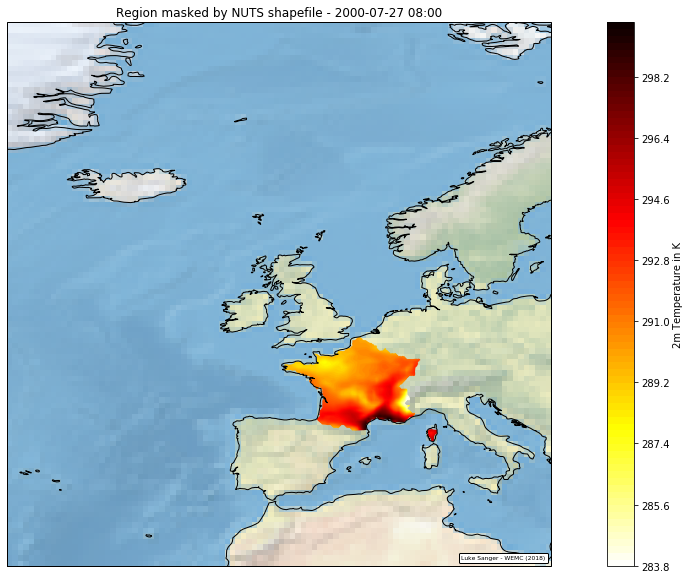

In [15]:
# plot to check area masking is correct
plt.figure(figsize=(20, 10),)
ax = plt.axes(projection=ccrs.PlateCarree())

# pick time slice and draw the contour with 100 levels + select appropriate cmap.
q = iris.plot.contourf(masked_cube[5000], 100, cmap='hot_r')

# add colour bar w/label
cb = plt.colorbar()
cb.set_label('2m Temperature in K')

# add coastlines to the map created by contourf.
ax.coastlines(resolution='50m')

# add stock background image
ax.stock_img()

# add title
plt.title('Region masked by NUTS shapefile - 2000-07-27 08:00')

# Add a citation to the plot.
iplt.citation('Luke Sanger - WEMC (2018)')

# set map limits to show only EU
ax.set_extent([-30.0, 20.0, 30.0, 80.0], ccrs.PlateCarree())

# show plot
plt.show()

In [12]:
# use iris function to get area weights
grid_areas = iris.analysis.cartography.cosine_latitude_weights(masked_cube)

In [13]:
new_cube = masked_cube.collapsed(['latitude','longitude'], iris.analysis.MEAN, weights=grid_areas)

/anaconda3/envs/wemc2/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/anaconda3/envs/wemc2/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [14]:
import iris.pandas
# convert to pandas series 
dfs = iris.pandas.as_series(new_cube)

# save as csv
dfs.to_csv('csv_name')